(diagnosing_with_divergences)=
# Diagnosing Biased Inference with Divergences

:::{post} Feb, 2018
:tags: hierarchical model, diagnostics
:category: intermediate
:author: Agustina Arroyuelo
:::

In [1]:
from collections import defaultdict

import arviz.preview as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.26.1


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-variat")
SEED = 20134234

This notebook is inspired by [Michael Betancourt's post on mc-stan](https://mc-stan.org/learn-stan/case-studies/divergences_and_bias.html), but we have adapted to reflect improvements in diagnostics since then and to show best practices. For discussion on the theory behind divergences and how they relate to biased inference, you can read [A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434).

Bayesian statistics is all about building a model and estimating the parameters in that model. However, a naive or direct parameterization of our probability model can sometimes be ineffective, you can check out Thomas Wiecki's blog post, [Why hierarchical models are awesome, tricky, and Bayesian](http://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/) on the same issue in PyMC. Suboptimal parameterization often leads to slow sampling, and more problematic, biased MCMC estimators. 

More formally, as explained in the original post, [Diagnosing Biased Inference with Divergences](http://mc-stan.org/documentation/case-studies/divergences_and_bias.html):

Markov chain Monte Carlo (MCMC) approximates expectations with respect to a given target distribution, 

$\mathbb{E}{\pi} [ f ] = \int \mathrm{d}q \, \pi (q) \, f(q)$ 

using the states of a Markov chain, ${q{0}, \ldots, q_{N} }$, 

$\mathbb{E}{\pi} [ f ] \approx \hat{f}{N} = \frac{1}{N + 1} \sum_{n = 0}^{N} f(q_{n})$

These estimators, however, are guaranteed to be accurate only asymptotically as the chain grows to be infinitely long, 

$\lim_{N \rightarrow \infty} \hat{f}{N} = \mathbb{E}{\pi} [ f ]$

To be useful in applied analyses, we need MCMC to converge to the true expectation values before we exhaust our finite computational resources. This fast convergence requires strong ergodicity conditions to hold, in particular geometric ergodicity between a Markov transition and a target distribution. Geometric ergodicity is usually the necessary condition for MCMC estimators to follow a central limit theorem, which ensures not only that they are unbiased even after only a finite number of iterations but also that we can empirically quantify their precision using the Monte Carlo standard error (mcse).

Unfortunately, proving geometric ergodicity is infeasible for any nontrivial problem. Instead, we must rely on empirical diagnostics that identify obstructions to geometric ergodicity, and hence well-behaved MCMC estimators. For a general Markov transition and target distribution, the best known diagnostic is $\hat{R}$ statistic over an ensemble of Markov chains initialized from diffuse points in parameter space; to do any better we need to exploit the particular structure of a given transition or target distribution.
 
Hamiltonian Monte Carlo, for example, is especially powerful in this regard as its failures to be geometrically ergodic with respect to any target distribution manifest in distinct behaviors that have been developed into sensitive diagnostics. One of these behaviors is the appearance of divergences that indicate the Hamiltonian Markov chain has encountered regions of high curvature in the target distribution which it cannot adequately explore.

In this notebook we aim to identify divergences and the underlying pathologies in `PyMC`.

## The Eight Schools Model

The hierarchical model of the Eight Schools dataset (Rubin 1981) as seen in `Stan`:

$\mu \sim \mathcal{N}(0, 5)\\$
$\tau \sim \text{Half-Cauchy}(0, 5)\\$
$\theta_{n} \sim \mathcal{N}(\mu, \tau)\\$
$y_{n} \sim \mathcal{N}(\theta_{n}, \sigma_{n}),$  

where $n \in \{1, \ldots, 8 \}$ and the $\{ y_{n}, \sigma_{n} \}$ are given as data.  

Inferring the hierarchical hyperparameters, $\mu$ and $\sigma$, together with the group-level parameters, $\theta_{1}, \ldots, \theta_{8}$, allows the model to pool data across the groups and reduce their posterior variance. Unfortunately, the direct *centered* parameterization also squeezes the posterior distribution into a particularly challenging geometry that obstructs geometric ergodicity and hence biases MCMC estimation.

In [3]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
# tau = 25.

In [4]:
with pm.Model() as Centered_eight:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

Unfortunately, this direct implementation of the model exhibits a pathological geometry that frustrates geometric ergodicity. To understand this bias, let's consider first a short Markov chain, commonly used when computational expediency is a motivating factor, and only afterwards a longer Markov chain.

### A Dangerously-Short Markov Chain

In [5]:
with Centered_eight:
    short_trace = pm.sample(200, random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Output()

Sampling 4 chains for 1_000 tune and 200 draw iterations (4_000 + 800 draws total) took 2 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


We can see a warning message indicating that we have several issues. $\hat{R}$ is too high, the effective samples size is too low and we have divergences. We can check the summary of the diagnostics:

In [6]:
az.summary(short_trace, kind="diagnostics", round_to=2)

ess_bulk  ess_tail  r_hat  mcse_mean  mcse_sd
mu           74.51    166.64   1.16       0.35     0.33
theta[0]     61.20    115.57   1.08       0.66     0.73
theta[1]    299.79    140.98   1.29       0.25     0.23
theta[2]    279.87    164.73   1.59       0.28     0.31
theta[3]    292.51    177.95   1.41       0.28     0.31
theta[4]    165.16     99.84   1.44       0.30     0.29
theta[5]     93.71    130.93   1.24       0.43     0.38
theta[6]    256.69     70.06   1.58       0.48     0.49
theta[7]    172.63     93.25   1.23       0.27     0.25
tau           7.13      4.17   1.62       0.84     0.87

Visually we can check if the chains have converged by plotting the trace:

In [7]:
az.plot_trace(short_trace);

In this example the problems are very clear to see, for many of the parameters, we can see that the chains have not mixed well and are stuck in different regions of the parameter space. But sometimes the problems are not so obvious. An alternative way to visualize sampling problems is through rank plots. Usually rank plots will detect more subtle problems with convergence that are not obvious in trace plots. For rank plots, we expect to see a uniform distribution of ranks across chains. The gray envelope indicates expected variability.

In [8]:
az.plot_rank(short_trace);

Let's focus now one parameter $\tau$, or more specifically, its logarithm, $log(\tau)$. Because $\tau$ is constrained to be positive, its logarithm will allow us to better resolve behavior for small values. Indeed the chains seems to be exploring both small and large values reasonably well.

Unfortunately, the resulting estimate for the mean of $log(\tau)$ is strongly biased away from the true value, here shown in grey.

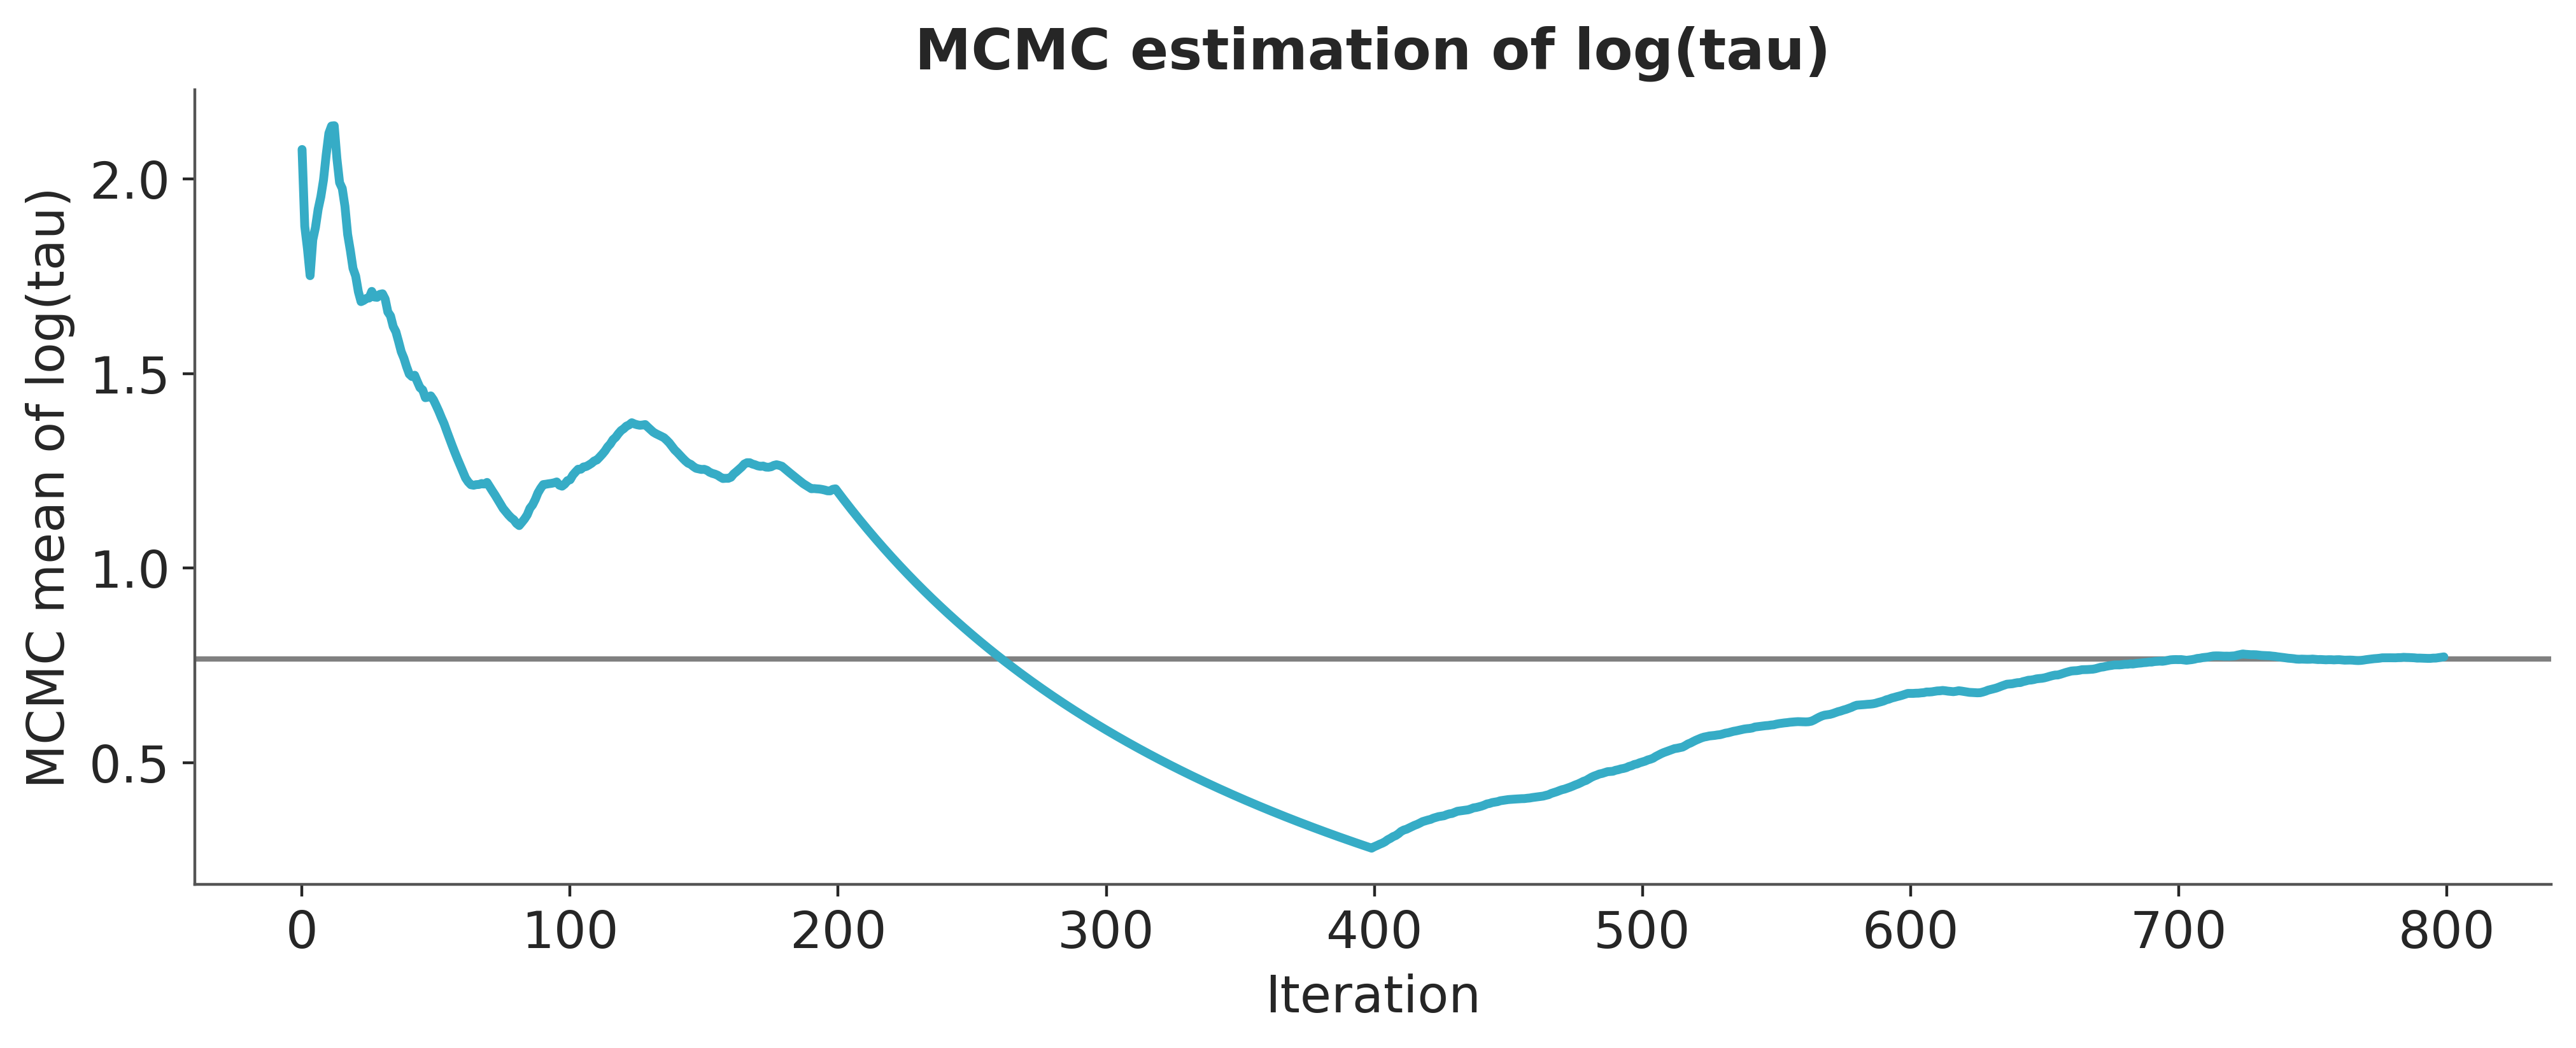

In [9]:
# plot the estimate for the cumulative mean of log(τ)
short_trace.posterior["log_tau"] = np.log(short_trace.posterior["tau"])
logtau = az.extract(short_trace, var_names=["log_tau"])
mlogtau = logtau.cumulative("sample").mean()

_, ax = plt.subplots(figsize=(10, 4))
ax.axhline(0.7657852, color="gray")
ax.plot(mlogtau, lw=2.5)
ax.set(xlabel="Iteration", ylabel="MCMC mean of log(tau)", title="MCMC estimation of log(tau)");

Hamiltonian Monte Carlo, however, is not so oblivious to these issues as $\approx$ 3% of the iterations in our lone Markov chain ended with a divergence.

In [10]:
# display the total number divergences and its percentage
divergent = short_trace.sample_stats["diverging"]
print(f"Number of Divergences {divergent.sum().item()}")
print(f"Percentage of Divergent {divergent.mean().item() * 100:.1f}")

Number of Divergences 36
Percentage of Divergent 4.5


Additionally, because the divergent transitions, here shown in green, tend to be located near the pathologies we can use them to identify the location of the problematic neighbourhoods in parameter space.

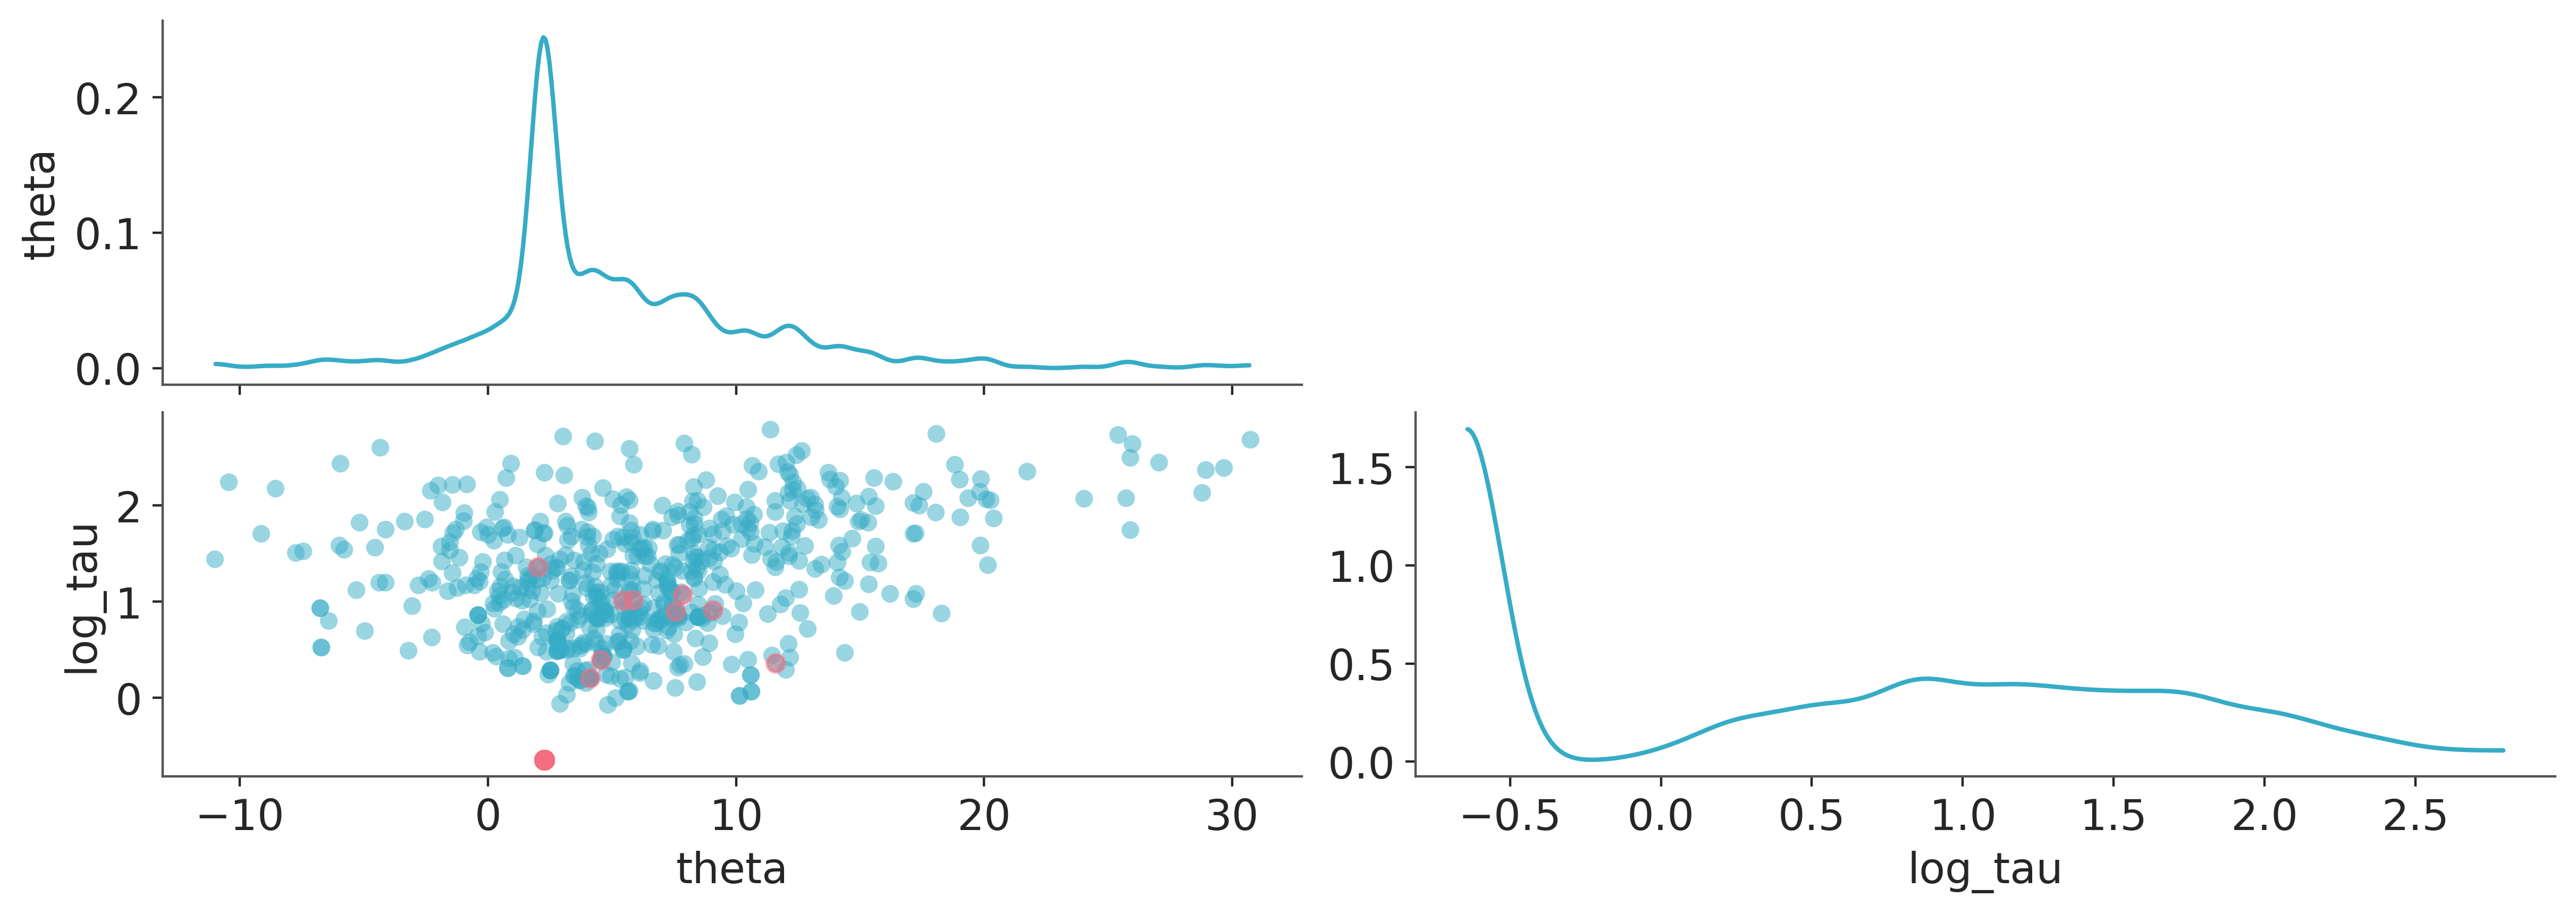

In [11]:
az.plot_pair(
    short_trace,
    var_names=["theta", "log_tau"],
    coords={"theta_dim_0": 0},
    visuals={"divergence": True},
);

It is important to point out that the pathological samples from the trace are not necessarily concentrated at the funnel: when a divergence is encountered, the subtree being constructed is rejected and the transition samples uniformly from the existing discrete trajectory. Consequently, divergent samples will not be located exactly in the region of high curvature.

There are many other ways to explore and visualize the pathological region in the parameter space. For example, we can reproduce Figure 5b in [Visualization in Bayesian workflow](https://arxiv.org/pdf/1709.01449.pdf)

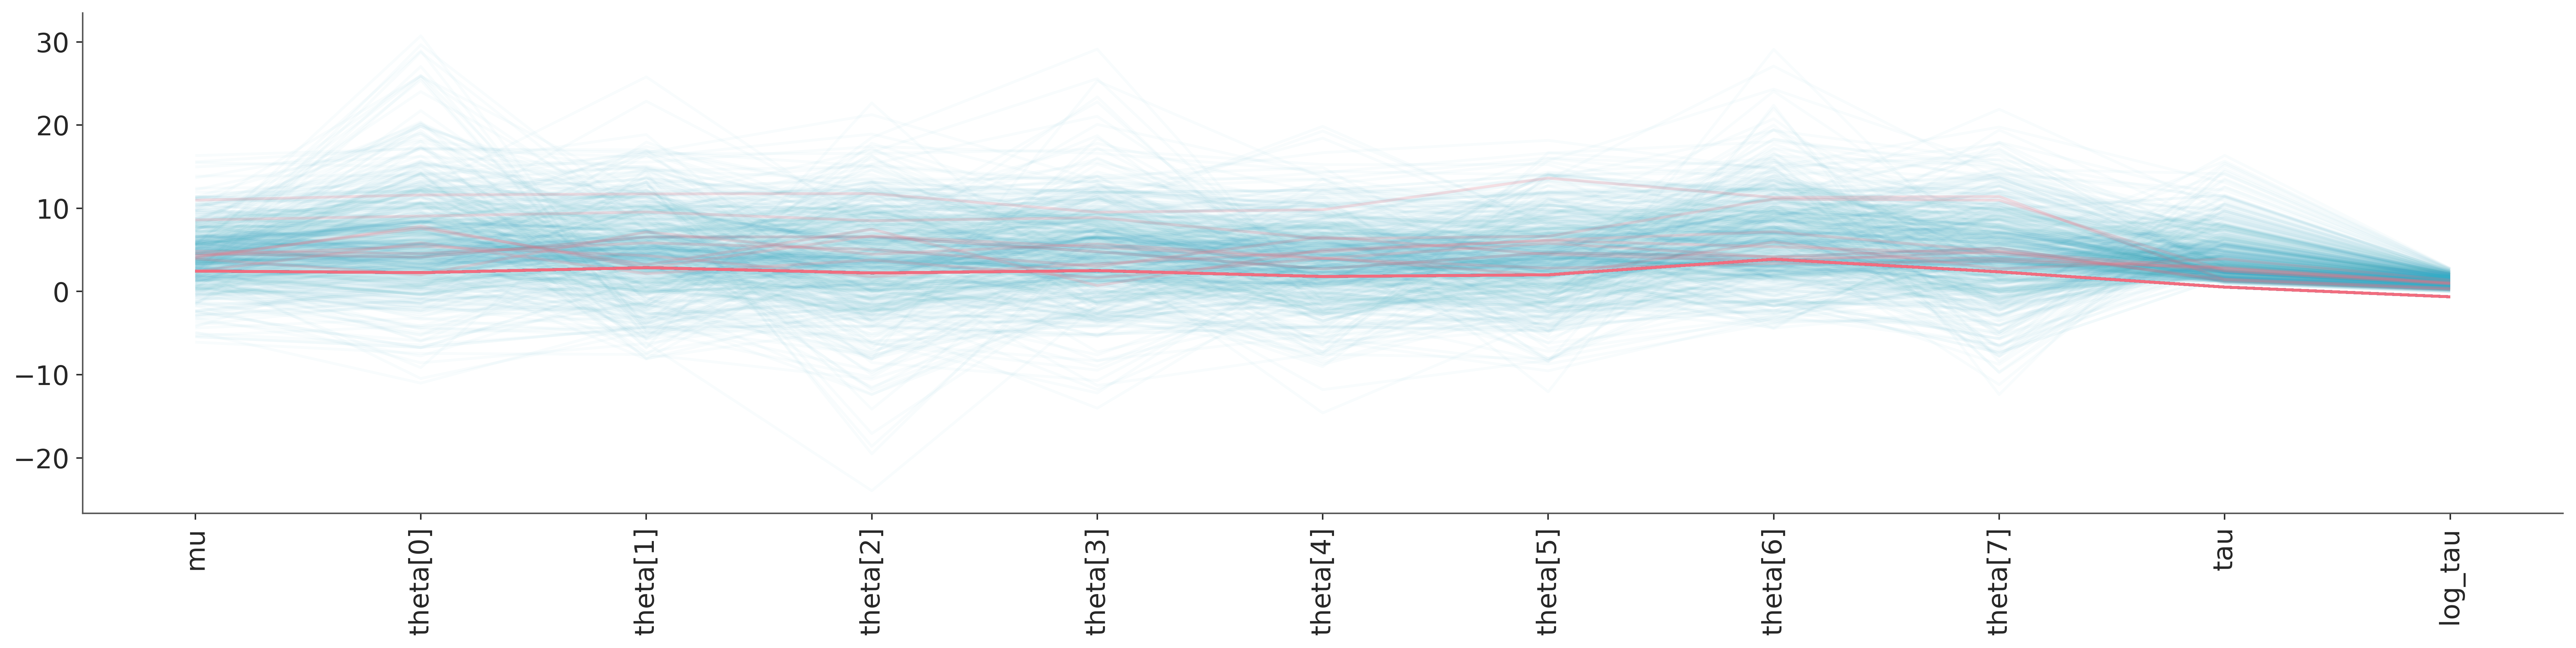

In [12]:
az.plot_parallel(short_trace);

### A Safer, Longer Markov Chain  

The recommended practice is to run multiple chains for a longer number of iterations. For diagnostic like $\hat{R}$ to be reliable it is recommended to run at least 4 chains and that each chain has at least 100 effective samples (a total of 400).

In [13]:
with Centered_eight:
    longer_trace = pm.sample(1000, chains=4, tune=1000, random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [14]:
az.summary(longer_trace, kind="diagnostics", round_to=2)

ess_bulk  ess_tail  r_hat  mcse_mean  mcse_sd
mu          585.23    564.64   1.01       0.14     0.11
theta[0]    173.52    843.73   1.03       0.37     0.39
theta[1]   1052.62    667.67   1.03       0.14     0.13
theta[2]   1127.27   1022.83   1.04       0.14     0.16
theta[3]   1017.34    921.18   1.03       0.15     0.14
theta[4]    867.43    923.01   1.03       0.16     0.15
theta[5]    999.43    932.10   1.03       0.15     0.13
theta[6]    324.53    754.89   1.02       0.34     0.31
theta[7]   1035.91    842.89   1.04       0.15     0.16
tau          12.00      5.74   1.25       0.61     0.91

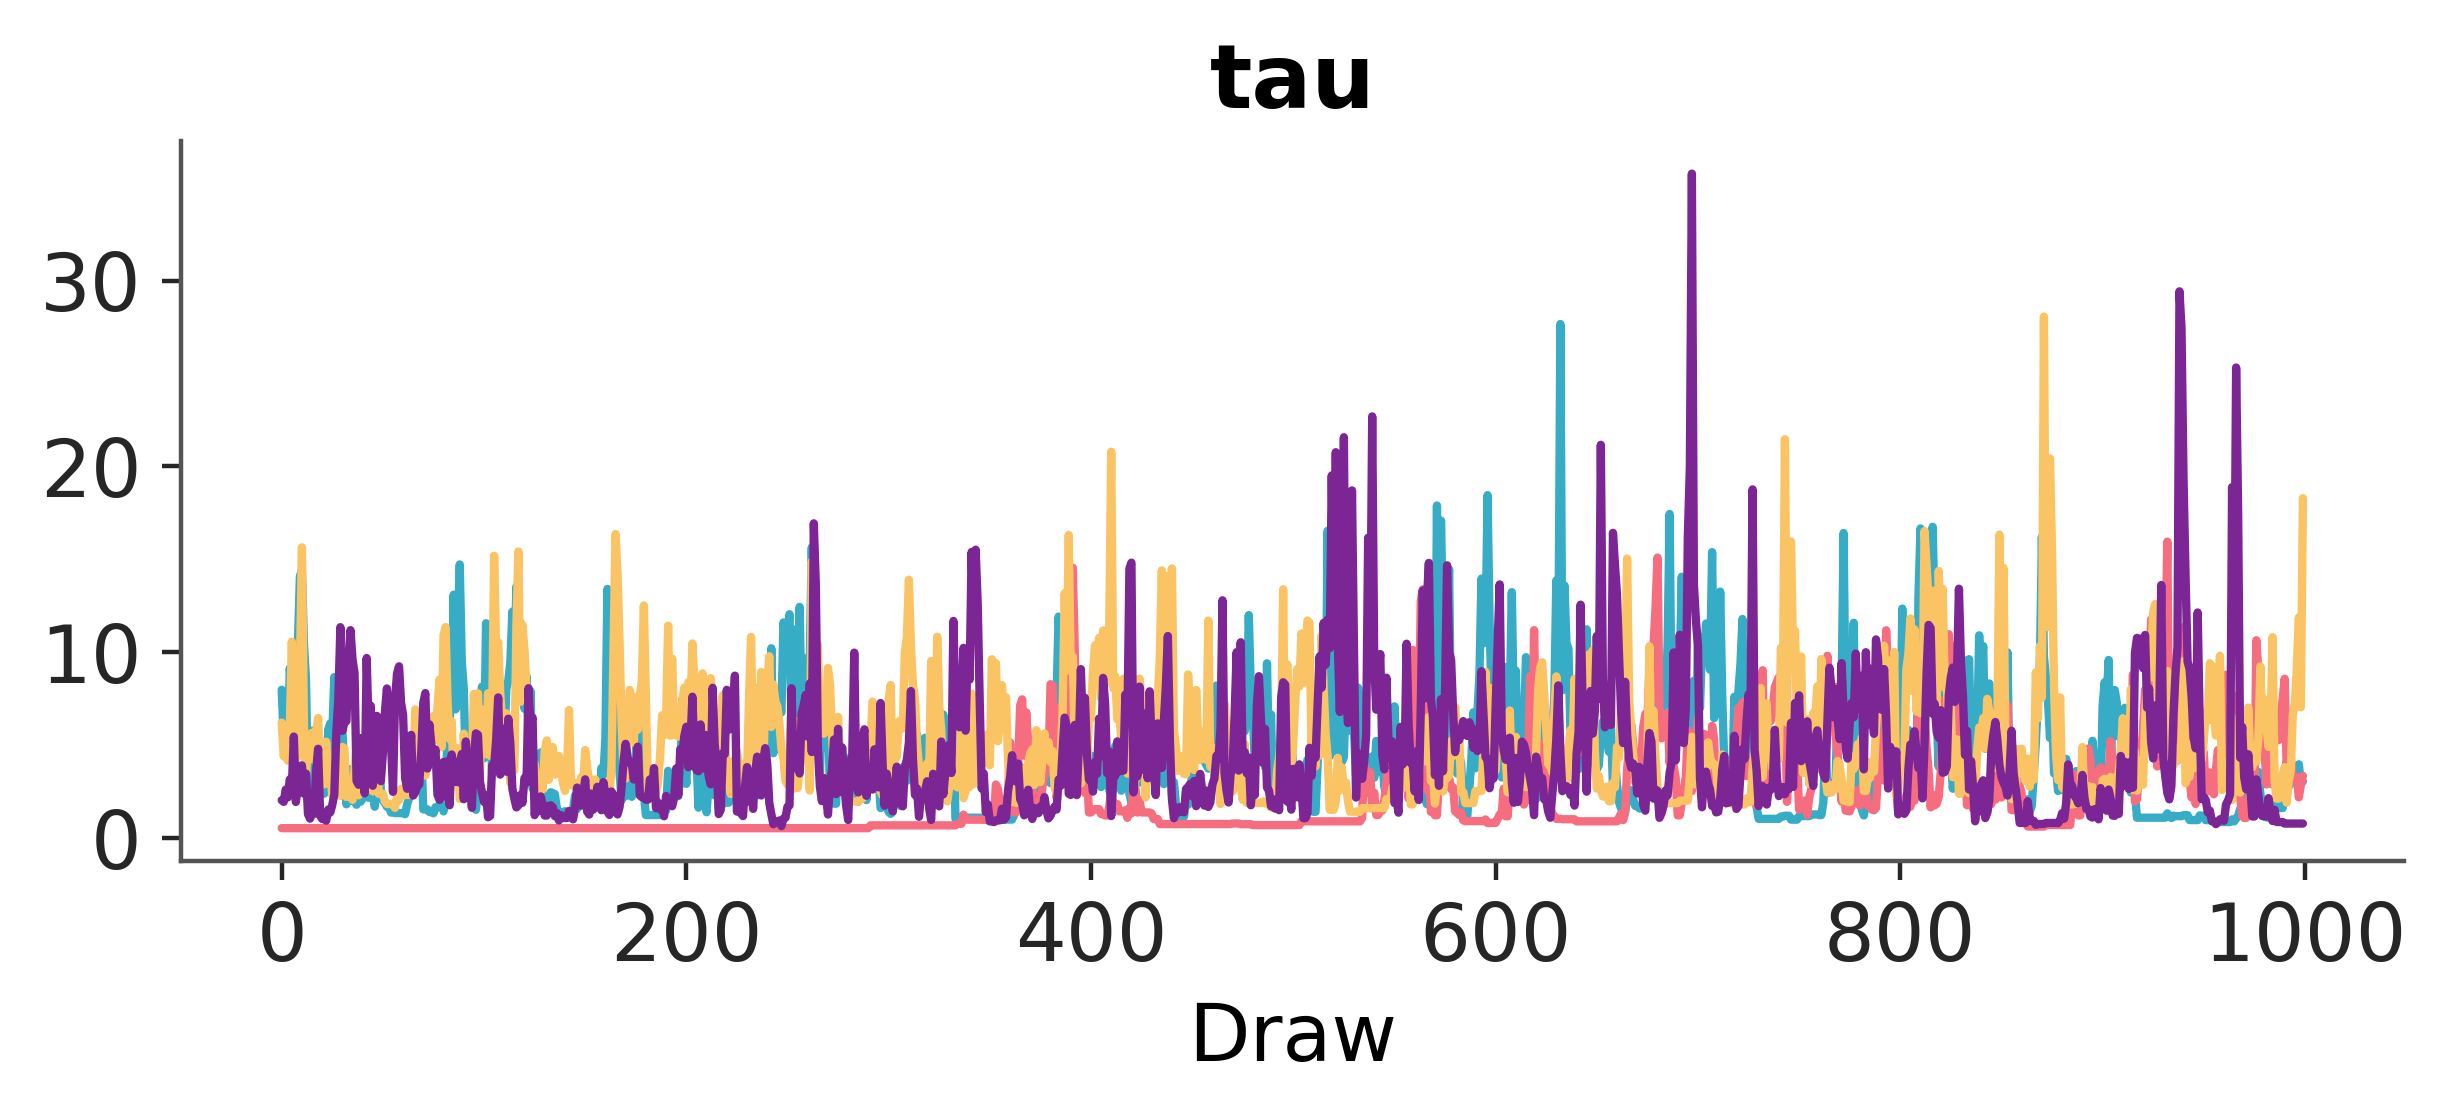

In [15]:
az.plot_trace(longer_trace, var_names=["tau"], visuals={"divergence": False});

We see problems with $\hat{R}$, the effective sample size (in particular for tau) does not indicate any serious issues. As shown in the trace plot, chains occasionally "sticks" as it approaches small values of $\tau$ (this is clearly seen for the "red" one), exactly where we saw the divergences concentrating. This is a clear indication of the underlying pathologies. These sticky intervals induce severe oscillations in the MCMC estimators early on, until they seem to finally settle into biased values.   

In fact the sticky intervals are the Markov chain trying to correct the biased exploration. If we ran the chain even longer then it would eventually get stuck again and drag the MCMC estimator down towards the true value. Given an infinite number of iterations this delicate balance asymptotes to the true expectation as we’d expect given the consistency guarantee of MCMC. Stopping after any finite number of iterations, however, destroys this balance and leaves us with a significant bias. More details can be found in the work by {cite:t}`betancourt2018`.

## Mitigating Divergences by Adjusting PyMC's Adaptation Routine

Divergences in Hamiltonian Monte Carlo arise when the Hamiltonian transition encounters regions of extremely large curvature, such as the opening of the hierarchical funnel. Unable to accurate resolve these regions, the transition malfunctions and flies off towards infinity. With the transitions unable to completely explore these regions of extreme curvature, we lose geometric ergodicity and our MCMC estimators become biased.

The default algorithm implemented in `PyMC` uses a heuristic to quickly identify these misbehaving trajectories, and hence label divergences, without having to wait for them to run all the way to infinity. This heuristic can be a bit aggressive, however, and sometimes label transitions as divergent even when we have not lost geometric ergodicity.

To resolve this potential ambiguity we can adjust the step size, $\epsilon$, of the Hamiltonian transition. The smaller the step size the more accurate the trajectory and the less likely it will be mislabeled as a divergence. In other words, if we have geometric ergodicity between the Hamiltonian transition and the target distribution then decreasing the step size will reduce and then ultimately remove the divergences entirely. If we do not have geometric ergodicity, however, then decreasing the step size will not completely remove the divergences.

The step size in `PyMC` is tuned automatically during warm up, but we can coerce smaller step sizes by tweaking the configuration of `PyMC`'s adaptation routine. In particular, we can increase the `target_accept` parameter from its default value of 0.8 closer to its maximum value of 1.

### Adjusting Adaptation Routine

In [16]:
with Centered_eight:
    fit_cp80 = pm.sample(tune=3000, target_accept=0.80, random_seed=SEED)
    fit_cp85 = pm.sample(tune=3000, target_accept=0.85, random_seed=SEED)
    fit_cp90 = pm.sample(tune=3000, target_accept=0.90, random_seed=SEED)
    fit_cp95 = pm.sample(tune=3000, target_accept=0.95, random_seed=SEED)
    fit_cp99 = pm.sample(tune=3000, target_accept=0.99, random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 5 seconds.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 5 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 7 seconds.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 8 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 17 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [17]:
df = pd.DataFrame([".80", ".85", ".90", ".95", ".99"], columns=["Delta_target"])

df["Step_size"] = pd.Series(
    [
        longer_trace.sample_stats["step_size"].mean().item(),
        fit_cp85.sample_stats["step_size"].mean().item(),
        fit_cp90.sample_stats["step_size"].mean().item(),
        fit_cp95.sample_stats["step_size"].mean().item(),
        fit_cp99.sample_stats["step_size"].mean().item(),
    ],
)

df["Divergences"] = pd.Series(
    [
        longer_trace.sample_stats["diverging"].sum().item(),
        fit_cp85.sample_stats["diverging"].sum().item(),
        fit_cp90.sample_stats["diverging"].sum().item(),
        fit_cp95.sample_stats["diverging"].sum().item(),
        fit_cp99.sample_stats["diverging"].sum().item(),
    ]
)
df

Delta_target  Step_size  Divergences
0          .80   0.241842          125
1          .85   0.155826           72
2          .90   0.147950          159
3          .95   0.121029           38
4          .99   0.039303            4

Here, the number of divergent tends to be smaller when delta increases. This behavior has a nice geometric intuition. The more we decrease the step size the more the Hamiltonian Markov chain can explore the neck of the funnel. Consequently, the marginal posterior distribution for $log (\tau)$ stretches further and further towards negative values with the decreasing step size. 

However, the Hamiltonian transition is still not geometrically ergodic with respect to the centered implementation of the Eight Schools model. Indeed, this is expected given the observed bias.

In [18]:
longer_trace.posterior["log_tau"] = np.log(longer_trace.posterior["tau"])
fit_cp80.posterior["log_tau"] = np.log(fit_cp80.posterior["tau"])
fit_cp85.posterior["log_tau"] = np.log(fit_cp85.posterior["tau"])
fit_cp90.posterior["log_tau"] = np.log(fit_cp90.posterior["tau"])
fit_cp95.posterior["log_tau"] = np.log(fit_cp95.posterior["tau"])
fit_cp99.posterior["log_tau"] = np.log(fit_cp99.posterior["tau"])

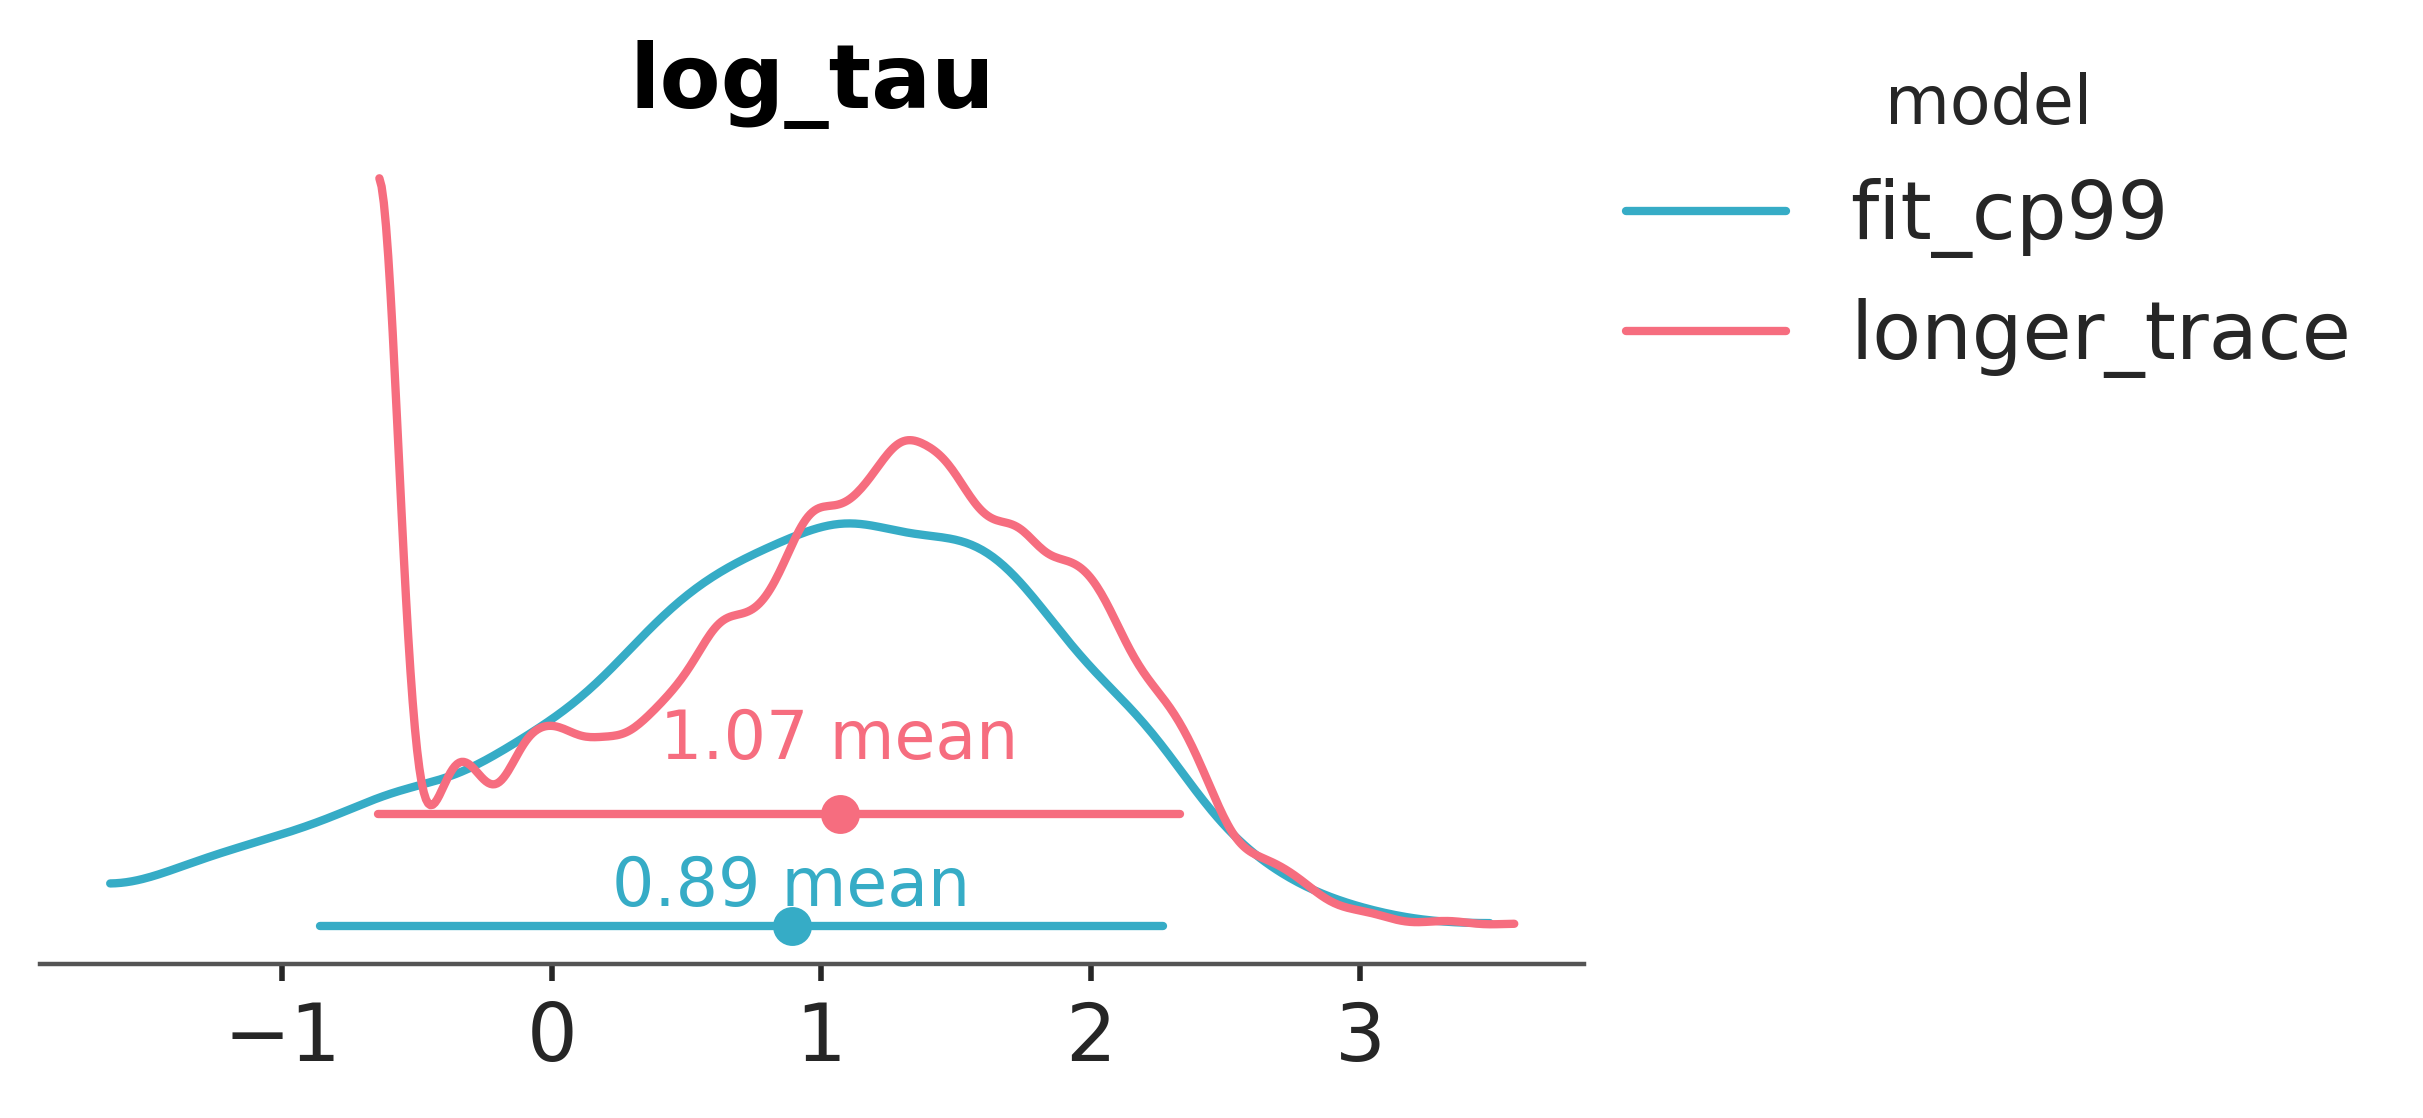

In [19]:
pc = az.plot_dist(
    {"fit_cp99": fit_cp99, "longer_trace": longer_trace},
    var_names=["log_tau"],
)
pc.add_legend("model");

In [20]:
_, ax = plt.subplots(figsize=(10, 4))

for target_accept, model in zip((0.8, 0.9, 0.99), (fit_cp85, fit_cp90, fit_cp99)):
    logtau = az.extract(model, var_names=["log_tau"])
    mlogtau = logtau.cumulative("sample").mean()
    ax.plot(mlogtau, lw=2.5, label=f"target_accept={target_accept:.2f}")

ax.axhline(0.7657852, color="gray")
ax.set(xlabel="Iteration", ylabel="MCMC mean of log(tau)", title="MCMC estimation of log(tau)")
ax.legend();

## A Non-Centered Eight Schools Implementation  
 
Although reducing the step size improves exploration, ultimately it only reveals the true extent the pathology in the centered implementation. Fortunately, there is another way to implement hierarchical models that does not suffer from the same pathologies.  

In a non-centered parameterization we do not try to fit the group-level parameters directly, rather we fit a latent Gaussian variable from which we can recover the group-level parameters with a scaling and a translation.  

$$\mu \sim \mathcal{N}(0, 5)$$
$$\tau \sim \text{Half-Cauchy}(0, 5)$$
$$\tilde{\theta}_{n} \sim \mathcal{N}(0, 1)$$
$$\theta_{n} = \mu + \tau \cdot \tilde{\theta}_{n}.$$

In [21]:
with pm.Model() as NonCentered_eight:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

In [22]:
with NonCentered_eight:
    fit_ncp80 = pm.sample(random_seed=SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta_t]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


We no longer see warnings about $\hat R$ or the effective sample size, still we get a few divergences. These infrequent divergences do not seem concentrate anywhere in parameter space, which is indicative of the divergences being false positives.

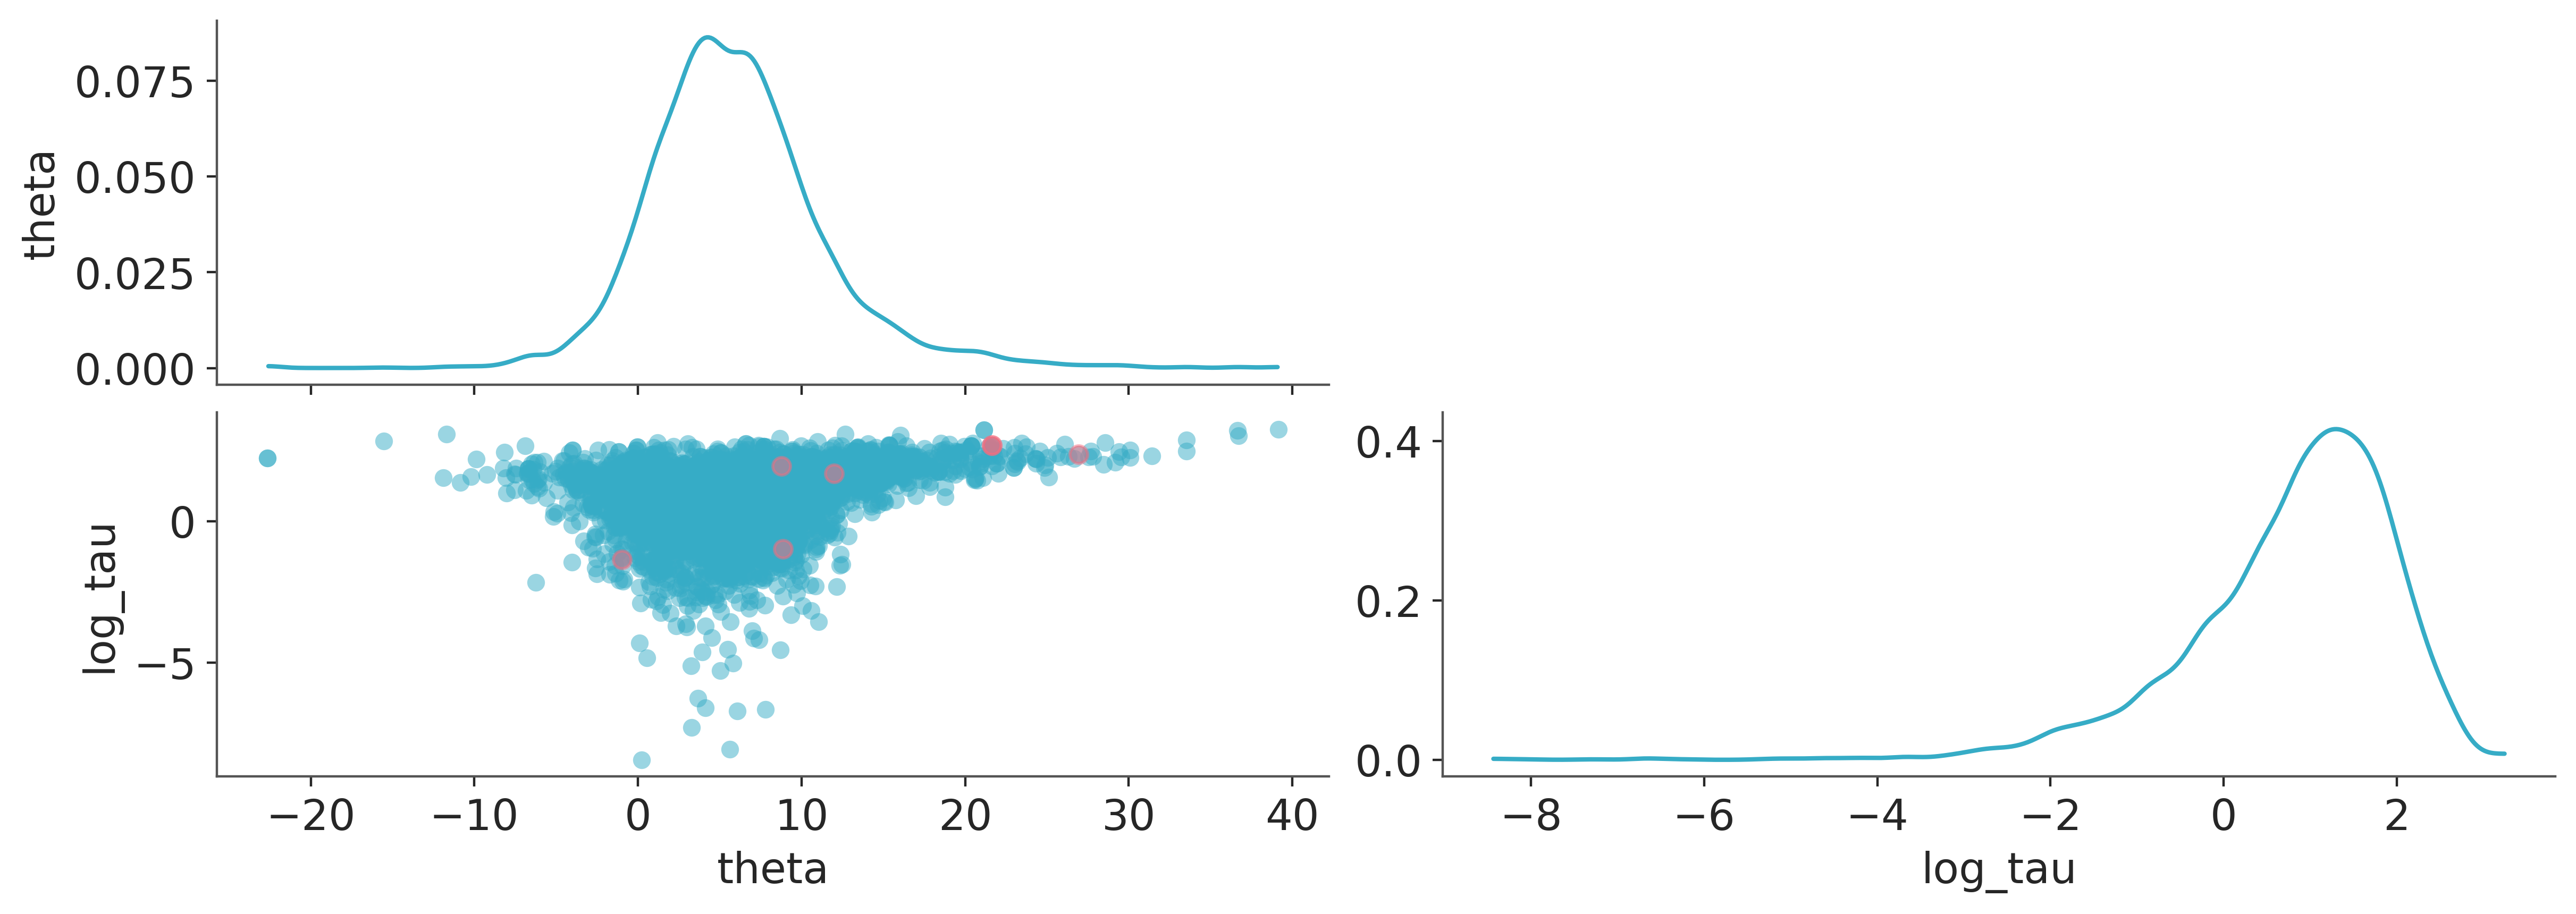

In [23]:
fit_ncp80.posterior["log_tau"] = np.log(fit_ncp80.posterior["tau"])

az.plot_pair(
    fit_ncp80,
    var_names=["theta", "log_tau"],
    coords={"theta_dim_0": 0},
    visuals={"divergence": True},
);

As expected of false positives, we can remove the divergences entirely by decreasing the step size.

In [24]:
with NonCentered_eight:
    fit_ncp90 = pm.sample(random_seed=SEED, target_accept=0.90)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta_t]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


The more agreeable geometry of the non-centered implementation allows the Markov chain to explore deep into the neck of the funnel, capturing even the smallest values of `tau` ($\tau$) that are consistent with the measurements. Consequently, MCMC estimators from the non-centered chain rapidly converge towards their true expectation values.

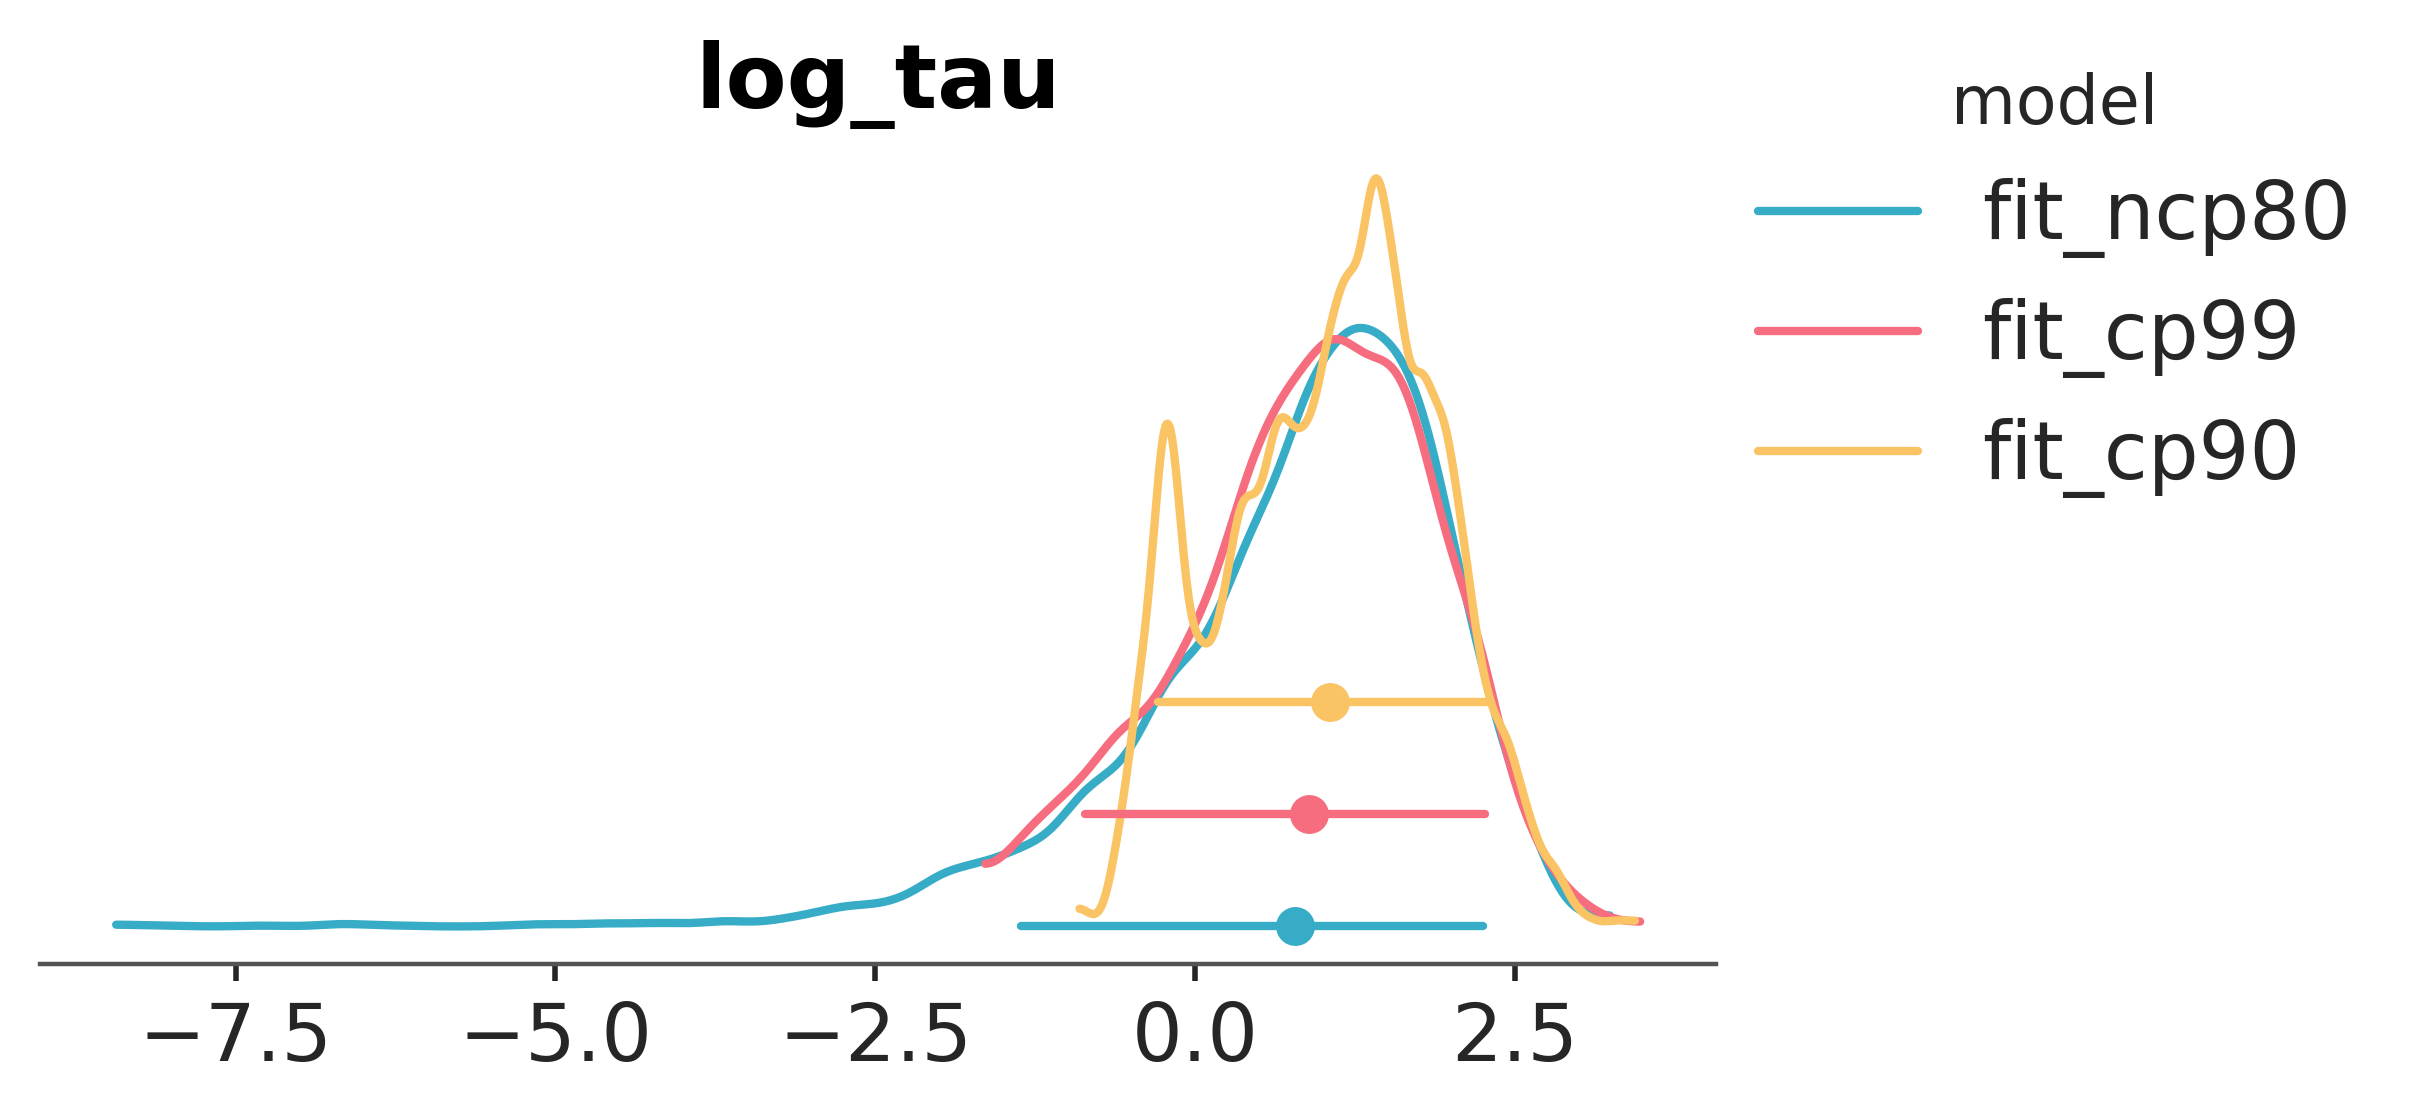

In [25]:
pc = az.plot_dist(
    {"fit_ncp80": fit_ncp80, "fit_cp99": fit_cp99, "fit_cp90": fit_cp90},
    var_names=["log_tau"],
    visuals={"point_estimate_text": False},
)
pc.add_legend("model");

## Authors
* Adapted from Michael Betancourt's post January 2017, [Diagnosing Biased Inference with Divergences](https://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html)
* Updated by Agustina Arroyuelo in February 2018, ([pymc#2861](https://github.com/pymc-devs/pymc/pull/2861))
* Updated by [@CloudChaoszero](https://github.com/CloudChaoszero) in January 2021, ([pymc-examples#25](https://github.com/pymc-devs/pymc-examples/pull/25))
* Updated Markdown and styling by @reshamas in August 2022, ([pymc-examples#402](https://github.com/pymc-devs/pymc-examples/pull/402))
* Updated and modified by Osvaldo Martin in Dec 2025

In [26]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Dec 04 2025

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.3.0

pymc      : 5.26.1
arviz     : 0.23.0.dev0
pandas    : 2.3.0
matplotlib: 3.10.3
numpy     : 2.2.6

Watermark: 2.5.0



:::{include} ../page_footer.md
:::